In [1]:
import faker
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import pandas as pd

### Utility functions

In [2]:
def make_email(name_first, name_last):
    '''Generates Email-Adresses for names'''
    email = []
    for first, last in zip(name_first, name_last):
        first, last = first.lower(), last.lower()
        if " " in first: first = "_".join(first.split(" "))
        if " " in last: last = "_".join(last.split(" "))
        
        email.append(f"{first}.{last}@{fake.free_email_domain()}")
        
    return email


    

### Data generation

In [3]:
np.random.seed(123)

## Initialize Faker
fake = faker.Faker('de_DE')
fake.seed_instance(456)

### Assumptions    ###
######################
n_sales_reps = 5 # Number of sales people
p_sales_rep = np.repeat(1/n_sales_reps, n_sales_reps) # Probability of sell per sales rep (default: equal probability)
trend_sales_rep = [3,3,2,1.5, 1.2] # Trend factor (3x beginning sales) MUST EQUAL LENGTH OF n_sales_reps
n_products = 6 # Number of different products
price_range = [10,50]
n_transactions = 10_000 # Number of transactions in total
n_units = np.arange(2, 50)
start, end = pd.to_datetime("09-01-2022"), pd.to_datetime("09-30-2022") # Start and end date of data set
good_rep = 3 # Sales name that has better weekend units

### Generated data ###
######################
price_product = np.round(np.random.uniform(low=price_range[0], high=price_range[1],size=n_products), 2)
id_product = np.arange(1,n_products+1)
product_2_price = {p_id:price for p_id, price in zip(id_product,price_product )}

names_reps = [fake.name() for _ in range(n_sales_reps)]
name_first_customer = [fake.first_name() for _ in range(n_transactions)]
name_last_customer = [fake.last_name() for _ in range(n_transactions)]
email_customer = make_email(name_first_customer, name_last_customer)
product_ids = np.random.choice(id_product, size=n_transactions)
rep_per_sale = np.random.choice(names_reps, size=n_transactions, p=p_sales_rep)
units_per_sale = np.random.choice(n_units, size=n_transactions)
iban_customer = [fake.iban() for _ in range(n_transactions)]
address = [fake.address() for _ in range(n_transactions)]
street = [el.split("\n")[0] for el in address]
city = [el.split("\n")[1] for el in address]
plz = [el.split(" ")[0] for el in city]

dates = [fake.date_between_dates(start, end) for _ in range(n_transactions)]
dates = np.sort(dates)

### Aggregate data to dataframe

In [6]:
data = {
        "Name1": name_first_customer, 
        "Name2": name_last_customer, 
        "iban": iban_customer, 
        "email": email_customer, 
        "Straße": street,
        "Ort": city,
        "plz": plz, 
        "Produkt-Nr.": product_ids, 
        "Menge": units_per_sale,
        "Vertriebler": rep_per_sale,     
        }
df_prelim = (pd.DataFrame(data)
             .assign(Preis=lambda _df: _df["Produkt-Nr."].replace(product_2_price))
            )
df_prelim.head()

,Name1,Name2,iban,email,Straße,Ort,plz,Produkt-Nr.,Menge,Vertriebler,Preis
0,Ferdi,Hartung,DE42196761743951330241,ferdi.hartung@aol.de,Börnerplatz 3,45618 Badibling,45618,2,2,Wilhelmine Mosemann MBA.,21.45
1,Hans-Hermann,Hande,DE78585540729472042831,hans-hermann.hande@gmx.de,Hüseyin-Kroker-Ring 0/8,80052 Eisenhüttenstadt,80052,1,33,August Nerger,37.86
2,Hans-Georg,Schulz,DE63116239997030155604,hans-georg.schulz@googlemail.com,Trubstraße 860,31611 Worbis,31611,2,34,Gottlieb Noack,21.45
3,Janette,Berger,DE02382897580735341327,janette.berger@gmail.com,Klaus-D.-Neuschäfer-Weg 9/0,38005 Gifhorn,38005,2,32,Reinhilde Seip-Benthin,21.45
4,Reinhart,Bender,DE44339782903456374877,reinhart.bender@gmail.com,Dorothea-Striebitz-Gasse 3,13989 Grimma,13989,1,10,Reinhilde Seip-Benthin,37.86


### Add data story

In [7]:
def add_trend(col_data):
    t_max = np.random.choice(trend_sales_rep)
    n = len(col_data)
    trend = np.linspace(1,t_max, num=n)
    e = np.random.rand(n) * 200
    res = np.maximum(trend * col_data.sort_values() + e, 1)
    return res

In [8]:
df = (df_prelim
      .assign(Menge=lambda _df: _df.groupby("Vertriebler")["Menge"].transform(add_trend), # Add general trend to "Menge"
              Datum=pd.to_datetime(dates))
      .assign(Menge=lambda _df: np.where((_df["Datum"].dt.weekday == 5) | (_df["Datum"].dt.weekday == 6), _df["Menge"] * 0.5, _df["Menge"])) # Add negative weekend trend
      .assign(Menge=lambda _df: np.where(((_df["Datum"].dt.weekday == 5) | (_df["Datum"].dt.weekday == 6)) & (_df["Vertriebler"] == names_reps[good_rep - 1]), _df["Menge"] * 1.8, _df["Menge"])) # Add good sales guy weekend upswing
      .assign(Menge=lambda _df: np.where((_df["plz"].str.startswith(r"8") | _df["plz"].str.startswith("9")), _df["Menge"] * 1.49, _df["Menge"])) # Add upswing for Region 8 and 9
      .reset_index(drop=True)
      .astype({"Menge": int})
     )
df.head()

,Name1,Name2,iban,email,Straße,Ort,plz,Produkt-Nr.,Menge,Vertriebler,Preis,Datum
0,Ferdi,Hartung,DE42196761743951330241,ferdi.hartung@aol.de,Börnerplatz 3,45618 Badibling,45618,2,166,Wilhelmine Mosemann MBA.,21.45,2022-09-01
1,Hans-Hermann,Hande,DE78585540729472042831,hans-hermann.hande@gmx.de,Hüseyin-Kroker-Ring 0/8,80052 Eisenhüttenstadt,80052,1,196,August Nerger,37.86,2022-09-01
2,Hans-Georg,Schulz,DE63116239997030155604,hans-georg.schulz@googlemail.com,Trubstraße 860,31611 Worbis,31611,2,181,Gottlieb Noack,21.45,2022-09-01
3,Janette,Berger,DE02382897580735341327,janette.berger@gmail.com,Klaus-D.-Neuschäfer-Weg 9/0,38005 Gifhorn,38005,2,76,Reinhilde Seip-Benthin,21.45,2022-09-01
4,Reinhart,Bender,DE44339782903456374877,reinhart.bender@gmail.com,Dorothea-Striebitz-Gasse 3,13989 Grimma,13989,1,26,Reinhilde Seip-Benthin,37.86,2022-09-01


## Summary of story

__Story 1__
- general increasing trend of units (not prices) over time
- leads to increase in sales over time

__Story 2__
- sales during weekends significantly worse (~50% less)
- but: one sales person does not have dip over weekend 
- HINT: dt.weekdays == 5 & == 6

__Story 3__
- regions are build by first number of plz
- regions starting with 8 and 9 are better
- HINT: extract PLZ from Ort (.str[0])

__Idee__
- add kv for contribution margin
- 



## Save data per region

In [9]:
from pathlib import Path

In [10]:
!pwd

/Users/felix/Dropbox/02_FH/01 Lehre/BA/Skript-Business-Analytics/chapters/assets/datasets/sales


In [17]:
for n,group in df.groupby(df["plz"].str[0]):
    fname = f"Region_{n}.xlsx"
    group = group.drop(labels="plz", axis=1)
    group.to_excel(fname, index=False)
    

## Read in Data (testing...) 

In [92]:
files = [f"Region_{i}.xlsx" for i in range(10)]
df = (pd.concat([pd.read_excel(file).assign(File=i) for i, file in enumerate(files)], axis=0)
         .assign(Umsatz=lambda _df: _df["Preis"] * _df["Menge"])
         .sort_values(by="Datum")
         .reset_index(drop=True)
     )
df

,Name1,Name2,iban,email,Straße,Ort,Produkt-Nr.,Menge,Vertriebler,Preis,Datum,File,Umsatz
0,Anne-Kathrin,Heintze,DE42654103349876737610,anne-kathrin.heintze@aol.de,Francisco-Eberth-Ring 4/7,00173 Bautzen,1,168,Gottlieb Noack,37.86,2022-09-01,0,6360.48
1,Julian,Lehmann,DE53565218728068846253,julian.lehmann@aol.de,Zirmering 771,66715 Greiz,2,176,Anett Hesse B.A.,21.45,2022-09-01,6,3775.20
2,Aline,Grein Groth,DE78679152604769826449,aline.grein_groth@gmail.com,Sepp-Seifert-Allee 1,68419 Bad Kreuznach,3,39,Gottlieb Noack,19.07,2022-09-01,6,743.73
3,Monika,Hauffer,DE10739457241480522766,monika.hauffer@web.de,Römergasse 5,68025 Geithain,1,125,Gottlieb Noack,37.86,2022-09-01,6,4732.50
4,Vadim,Steinberg,DE27075733551936580678,vadim.steinberg@yahoo.de,Bodo-Wähner-Weg 958,65232 Stade,4,186,Reinhilde Seip-Benthin,32.05,2022-09-01,6,5961.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Laszlo,Schleich,DE60017400519501350374,laszlo.schleich@yahoo.de,Mechthild-Bohlander-Gasse 45,38416 Niesky,4,168,August Nerger,32.05,2022-09-29,3,5384.40
9996,Katarzyna,Plath,DE08598042369759922423,katarzyna.plath@aol.de,Holtstr. 6,31244 Sulzbach-Rosenberg,4,291,Reinhilde Seip-Benthin,32.05,2022-09-29,3,9326.55
9997,Björn,Bolander,DE32866004281353444956,björn.bolander@gmx.de,Ilonka-Trommler-Platz 0,36842 Wittenberg,3,228,Wilhelmine Mosemann MBA.,19.07,2022-09-29,3,4347.96
9998,Erhardt,Trommler,DE02698797401150171337,erhardt.trommler@hotmail.de,Hoffmannstr. 9,34162 Mayen,4,77,Wilhelmine Mosemann MBA.,32.05,2022-09-29,3,2467.85


,Umsatz,Menge,Preis
Produkt-Nr.,,,
1,9006704.70,141.267815,37.86
2,4923311.25,139.613747,21.45
3,4381675.76,137.338912,19.07
4,7760490.85,139.479839,32.05
5,8932081.06,140.272229,38.78
6,6151812.24,140.975941,26.92


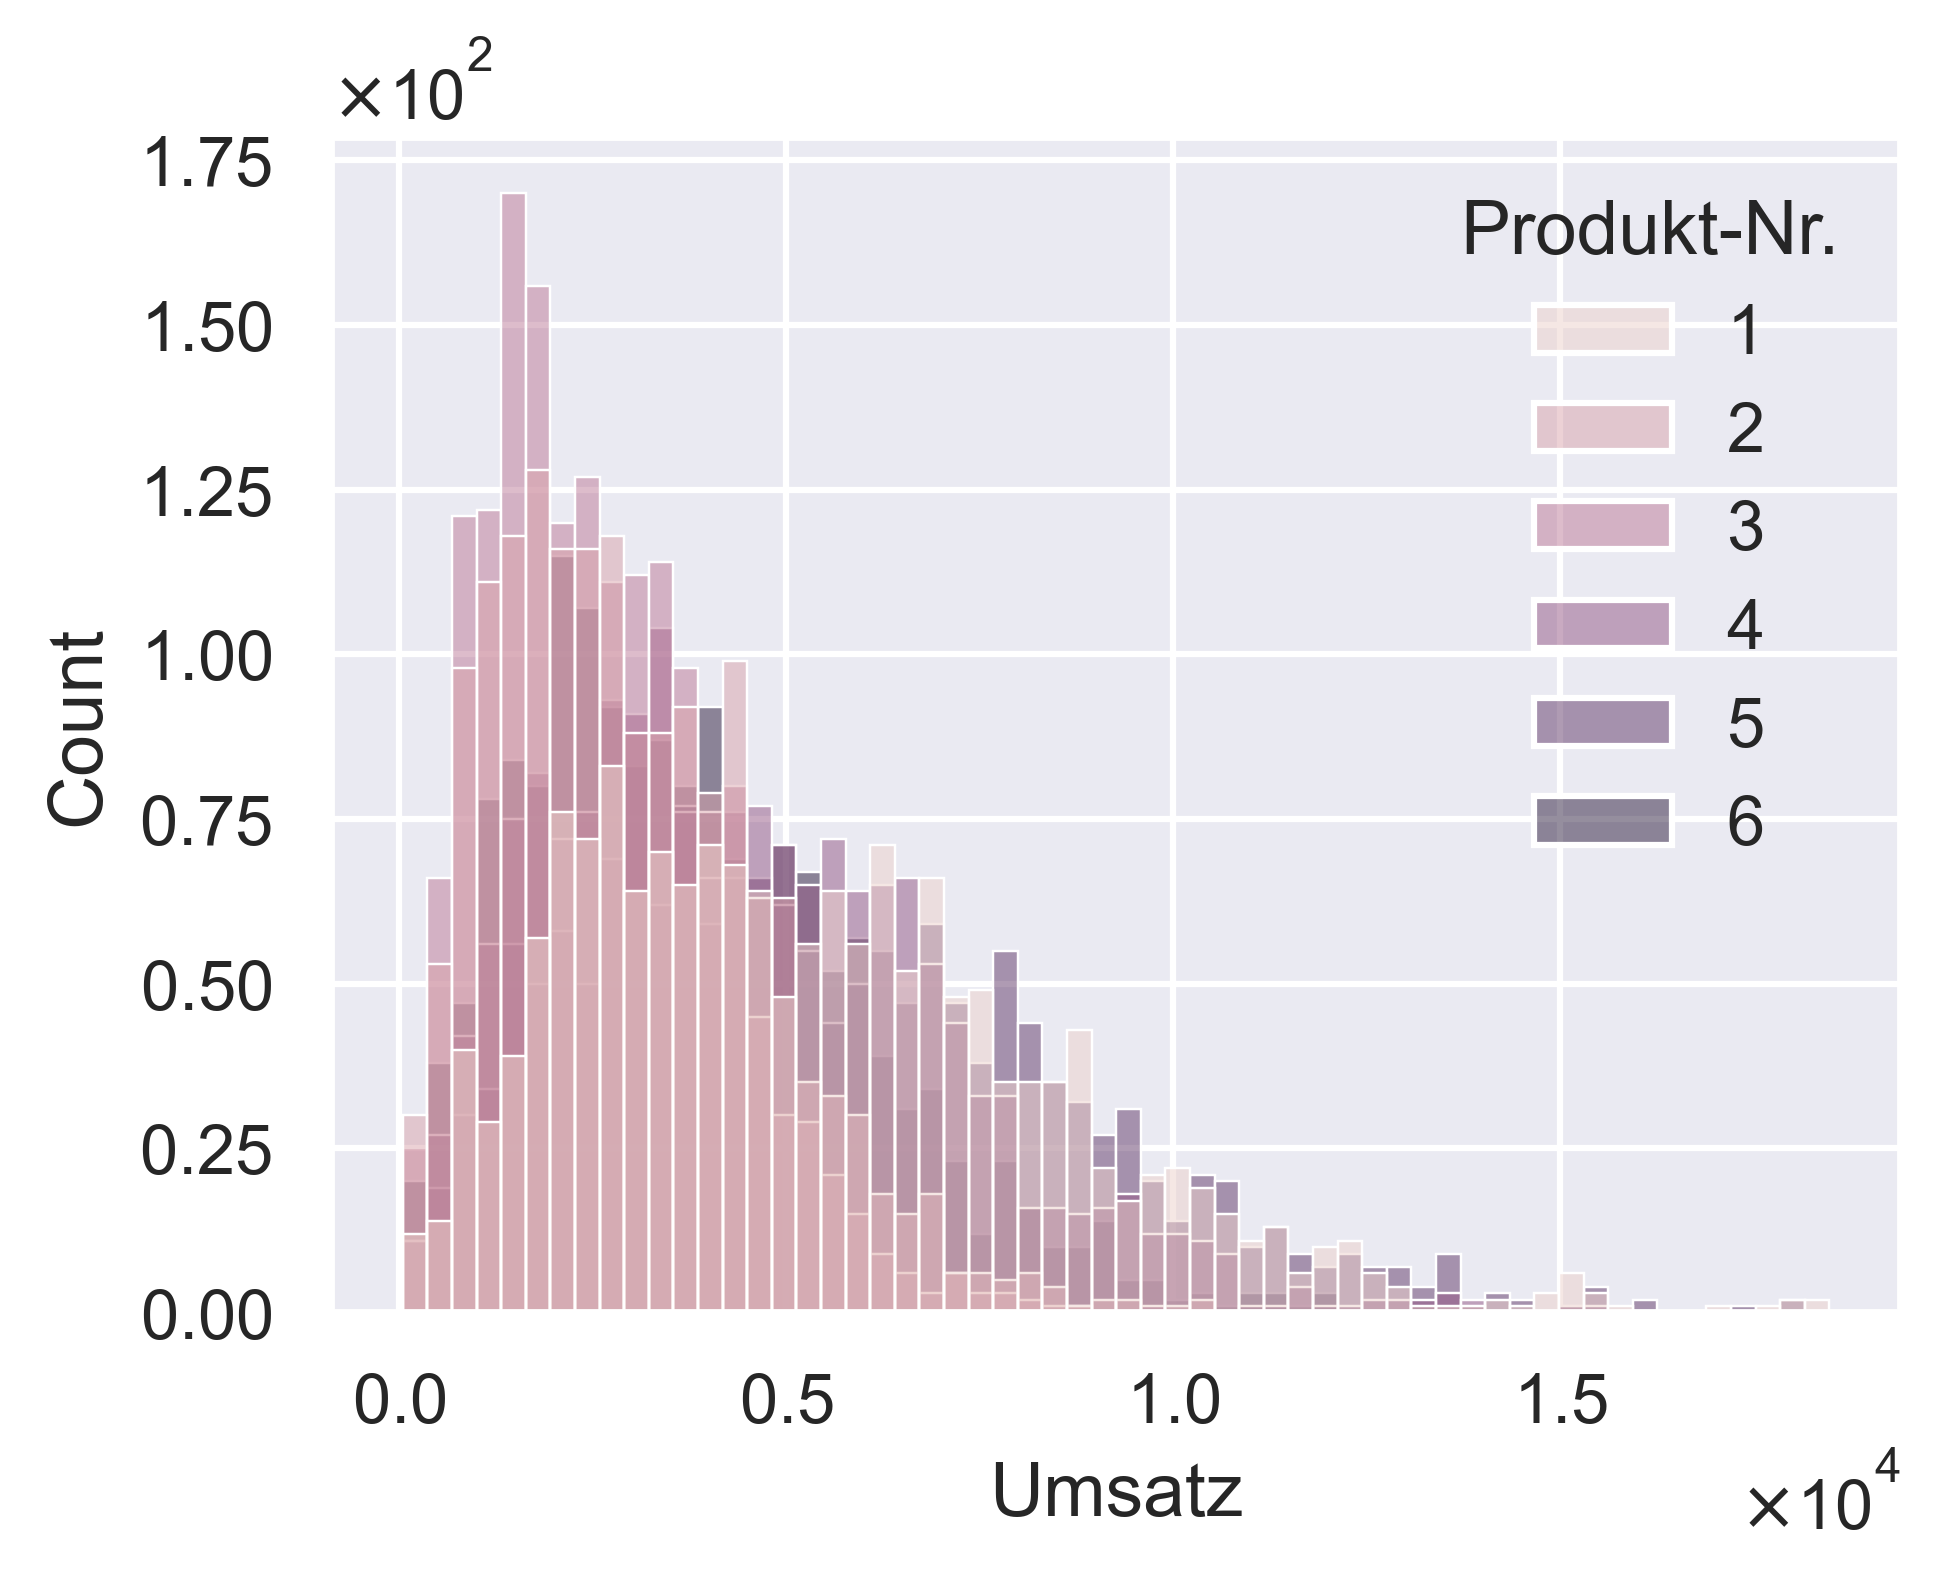

In [98]:
sns.histplot(data=df, x="Umsatz", hue="Produkt-Nr.")
df.groupby("Produkt-Nr.").agg({"Umsatz": np.sum, "Menge":np.mean, "Preis": np.mean})